In [1]:
import time
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def loadData(fileNameStr):
    df = pd.read_csv(fileNameStr,sep=' ', header=None)
    df.columns = ['cityNumber', 'x', 'y']
    xs = df.y
    ys = df.x
    return xs, ys

In [3]:
#functions used to build the distance matrix
def distanceScalar(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def createDistanceMatrix(xs, ys):
    numPoints = len(xs)
    dists = np.ndarray((numPoints,numPoints))
    for i in range(numPoints):
        dists[i,i] = 0
        for j in range(i+1,numPoints):
            dists[i,j] = distanceScalar(xs[i], ys[i], xs[j], ys[j])
            dists[j,i] = dists[i,j]   
    return dists

In [4]:
def routeLength(path, distancesMatrix):
    # index 0 not included in the path as we're assuming 0 is starting point
    curLength = distancesMatrix[0,path[0]]
    for i in range(len(path)-1):
        curLength += distancesMatrix[path[i], path[i+1]]
    curLength += distancesMatrix[path[-1],0]
    return curLength

In [5]:
def visualiseRoute(xs, ys, path, routeLength):
    fig, ax = plt.subplots(1,1)
    dash = [5, 5]
    ax.scatter(xs[0],ys[0], color='black')
    ax.scatter(xs[1:], ys[1:], color='blue')
    ax.plot([xs[0],xs[path[0]]],[ys[0],ys[path[0]]], color='red', dashes=dash)
    for i in range(numPoints-2):
        ax.plot([xs[path[i]],xs[path[i+1]]],[ys[path[i]],ys[path[i+1]]], color='red', dashes=dash)
    ax.plot([xs[0],xs[path[-1]]],[ys[0],ys[path[-1]]], color='red', dashes=dash)    
    ax.set_title('Route length: {:.3}'.format(routeLength))

In [6]:
class TSP_evaluator:
    # helper class for simulated annealing algorithm
    def __init__(self, distMatrix):
        self.mDists = distMatrix
        self.dim = distMatrix.shape[0]
        self.pool = [i for i in range(self.dim-1)]
        
    def evaluate(self, path):
        # Returns the path length
        return routeLength(path, self.mDists)
    
    def randomSolution(self, initSolution):
        # Returns a random solution around initSolution
        return self.rebranching(initSolution)
    
    def rebranching(self, initSolution):
        # Given a current solution [c1, c2, ..., ck1, ck1+1, ...,  ck2-1, ck2, ..., cn]
        # returns a new solution [c1, c2, ..., ck2, ck2-1, ..., ck1+1, ck1, ..., cn ]
        # where k1 and k2 are chosen randomly
        
        k1, k2 = random.sample(self.pool, 2)
        k1, k2 = min(k1,k2), max(k1, k2)
        newSolution = list(initSolution)
        for l in range(1+int(0.5*(k2-k1-1))):
            newSolution[k1+l], newSolution[k2-l] = newSolution[k2-l], newSolution[k1+l]
        return newSolution


In [7]:
def simulatedAnnealing(objFun, minMax, xStart, initTemp, finalTemp, coolFactor, maxIterPerTemp):
    # objFun : the function to optimize
    # minMax : 1 to minimize, -1 to maximize
    # xStart: starting point of the search
    # initTemp: initial Temperature
    # finalTemp: finalTemperature
    # coolFactor: parameters <1
    #             At each step temperature change, new temp = current temp * coolFactor
    # searchRadius: the radius of the ball inside which we look for a solution. 
    #               When current temperature < 1, the new search radius = current search radius * coolFactor
    # maxIterTemp: the maximum number of iterations we perform once we found a new optimum at a given temperature
    #              This defines the equilibrium condition at a given temperature, ie we've iterated maxIterPerTemp 
    #              without finding a better solution
    
    # Note on implementation:
    # When the current temperature falls below 1, the search radius gets multiplied by the coolFactor
    # This allows for intensification when we're near the end of the algorithm
    
    # Please note this is a custom implementation of simulated annealing. It was implemented so as to 
    # allow better identification of which parameter to change when convergence isn't obtained.
    # To achieve this, the algorithm "normalizes" delta (the change in energy) using the average delta 
    # at the equilibrium position for a given temperature. This avoids having to adjust for initial temperatures
    # and final temperatures so that the order of magnitude depends on the energy delta. We get a better control
    # of the barrier level for diversification.
    
    curTemp = initTemp
    xBest = np.copy(xStart)
    fxBest = objFun.evaluate(xBest) * minMax
    
    # to store all evaluated points and associated function values
    xIter = []
    fxIter = []
    
    # to store best x and f(xBest) for a given temperature
    bestxTemp = []
    bestfxTemp = []
    probs = []
        
    iterCount = 0
    while curTemp > finalTemp:
        #restarting from our equilibrium point (ie best value so far)
        x = np.copy(xBest)
        fx = fxBest
        iterCount = 0
        deltaAvg = 0
        probVec = []
        
        #we reach equilibrium at this temperature if we iterated maxIterPerTemp times without improving the best solution
        while iterCount < maxIterPerTemp:
            xTest = objFun.randomSolution(x)
            fxTest = objFun.evaluate(xTest) * minMax
            delta = fxTest - fx
            deltaAvg = (iterCount*deltaAvg+abs(delta))/(iterCount+1)
            
            if delta >0:
                lim_prob = np.exp(-(delta/deltaAvg)/curTemp)
                probVec.append(lim_prob)

            if delta <= 0 or np.random.random() < np.exp(-(delta/deltaAvg)/curTemp):
                x = np.copy(xTest)
                fx = fxTest
            iterCount+=1
            if fxTest < fxBest:
                #we improved the best solution, reset iterCount to 0 and store new best solution 
                iterCount = 0
                deltaAvg = 0
                xBest = np.copy(xTest)
                fxBest = fxTest

            xIter.append(x)
            fxIter.append(objFun.evaluate(x))
        bestxTemp.append(xBest)
        bestfxTemp.append(objFun.evaluate(xBest))
        probs.append(np.mean(probVec))

        curTemp *= coolFactor

    return bestxTemp, bestfxTemp, xIter, fxIter, probs

In [8]:
fileName = 'Djibouti_38_coordinates.tsp'
knownOptimum = 6656

xs, ys = loadData(r'.\\data\\' + fileName)
numPoints = len(xs)

dists = createDistanceMatrix(xs, ys)

In [11]:
tspEval = TSP_evaluator(dists)

initTemp = 10
finalTemp = 0.008
coolFactor = 0.9
maxIterTemp = 10 * numPoints

minMax = 1  #minimize = 1, maximize = -1

# start from a random solution
x = [i for i in range(1, numPoints)]
random.shuffle(x)

startTime = time.time()
paths, pathLengths, xEvals, fxEvals, probs = simulatedAnnealing(tspEval, minMax, x, initTemp, finalTemp, coolFactor, maxIterTemp)
runTime = time.time() - startTime

path = paths[-1]
pathLength = pathLengths[-1]

print('Path Length: {:.0f}'.format(pathLength))
print('True Minimum: {}'.format(knownOptimum))
print('Solution: {}'.format(path))
print('Computational time: {:.2f} s'.format(runTime))
print('Number of function evaluations: {}'.format(len(fxEvals)))


Path Length: 6659
True Minimum: 6656
Solution: [ 9 13 20 28 29 31 34 36 37 32 33 35 30 26 27 23 21 24 25 22 19 14 12 15
 16 17 18 10 11  8  7  6  5  4  2  3  1]
Computational time: 3.83 s
Number of function evaluations: 31031


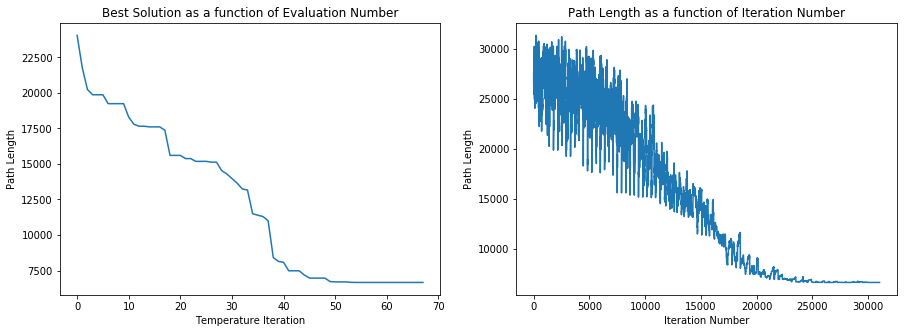

In [12]:
tempZoom = 0
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot([i for i in range(tempZoom, len(pathLengths))], np.array(pathLengths[tempZoom:]))
ax[1].plot([i for i in range(len(xEvals))], np.array(fxEvals))

ax[0].set_xlabel('Temperature Iteration')
ax[0].set_ylabel('Path Length')
ax[0].set_title('Best Solution as a function of Evaluation Number')

ax[1].set_xlabel('Iteration Number')
ax[1].set_ylabel('Path Length')
ax[1].set_title('Path Length as a function of Iteration Number')

plt.savefig('convergenceCurves')

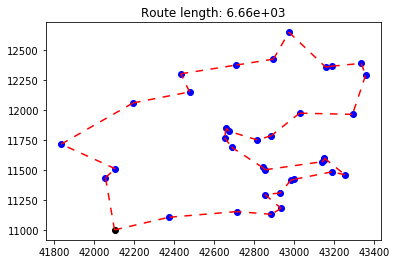

In [13]:
visualiseRoute(xs, ys, path, pathLength)
plt.savefig('Path')

In [15]:
# Solution:
print('city: {} \t x: {} \t y: {} '.format(0, xs[0], ys[0]))
for i in range(numPoints-1):
    print('city: {} \t x: {} \t y: {}  '.format(path[i], xs[path[i]], ys[path[i]]))

city: 0 	 x: 42102.5 	 y: 11003.6111 
city: 9 	 x: 42057.2222 	 y: 11438.3333  
city: 13 	 x: 42106.3889 	 y: 11511.3889  
city: 20 	 x: 41836.1111 	 y: 11715.8333  
city: 28 	 x: 42195.5556 	 y: 12058.3333  
city: 29 	 x: 42477.5 	 y: 12149.4444  
city: 31 	 x: 42433.3333 	 y: 12300.0  
city: 34 	 x: 42711.3889 	 y: 12372.7778  
city: 36 	 x: 42895.5556 	 y: 12421.6667  
city: 37 	 x: 42973.3333 	 y: 12645.0  
city: 32 	 x: 43156.3889 	 y: 12355.8333  
city: 33 	 x: 43189.1667 	 y: 12363.3333  
city: 35 	 x: 43334.7222 	 y: 12386.6667  
city: 30 	 x: 43355.5556 	 y: 12286.9444  
city: 26 	 x: 43290.5556 	 y: 11963.0556  
city: 27 	 x: 43026.1111 	 y: 11973.0556  
city: 23 	 x: 42884.4444 	 y: 11785.2778  
city: 21 	 x: 42814.4444 	 y: 11751.1111  
city: 24 	 x: 42673.6111 	 y: 11822.7778  
city: 25 	 x: 42660.5556 	 y: 11846.9444  
city: 22 	 x: 42651.9444 	 y: 11770.2778  
city: 19 	 x: 42686.6667 	 y: 11690.5556  
city: 14 	 x: 42841.9444 	 y: 11522.2222  
city: 12 	 x: 42855.2778 	